In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import prince
from scipy.stats import chi2_contingency

In [3]:
df = pd.read_csv("Depression Student Dataset.csv")
print(df)

     Gender  Age  Academic Pressure  Study Satisfaction     Sleep Duration  \
0      Male   28                2.0                 4.0          7-8 hours   
1      Male   28                4.0                 5.0          5-6 hours   
2      Male   25                1.0                 3.0          5-6 hours   
3      Male   23                1.0                 4.0  More than 8 hours   
4    Female   31                1.0                 5.0  More than 8 hours   
..      ...  ...                ...                 ...                ...   
497    Male   26                5.0                 2.0  More than 8 hours   
498    Male   24                2.0                 1.0  Less than 5 hours   
499  Female   23                3.0                 5.0          5-6 hours   
500    Male   33                4.0                 4.0  More than 8 hours   
501    Male   18                5.0                 3.0  More than 8 hours   

    Dietary Habits Have you ever had suicidal thoughts ?  Study

In [4]:
def get_contingency_table(dataframe, index_column1, index_column2):
    return pd.crosstab(dataframe[dataframe.columns[index_column1]], dataframe[dataframe.columns[index_column2]])

print(get_contingency_table(df, 2, 3))

Study Satisfaction  1.0  2.0  3.0  4.0  5.0
Academic Pressure                          
1.0                  18   17   25   22   17
2.0                   9   12   19   23   25
3.0                  19   26   22   36   22
4.0                  16   19   23   17   17
5.0                  24   26   14   18   16


In [8]:
print(get_contingency_table(df, 3, 4))

Sleep Duration      5-6 hours  7-8 hours  Less than 5 hours  More than 8 hours
Study Satisfaction                                                            
1.0                        19         20                 23                 24
2.0                        25         25                 25                 25
3.0                        25         33                 19                 26
4.0                        29         31                 29                 27
5.0                        25         19                 27                 26


In [9]:
def select_d(dataframe, select_depressive):
    if select_depressive == 0:
        filtered_df = dataframe[dataframe[dataframe.columns[-1]] != "Yes"]
    elif select_depressive == 1:
        filtered_df = dataframe[dataframe[dataframe.columns[-1]] != "No"]
    else:
        filtered_df = dataframe
    return filtered_df

In [93]:
def chi2_test(dataframe, index_column1, index_column2, select_depressive):
    """
    Renvoie la p-valeur du test "la colonne index_column1 et index_column2 sont indépendantes",
    si elle est en dessous de .05, alors les colonnes sont corrélées
    """
    filtered_df = select_d(dataframe, select_depressive)

    cont_table = get_contingency_table(filtered_df, index_column1, index_column2)

    _, p, _, _ = chi2_contingency(cont_table)

    return p

In [90]:
def make_plot(dataframe, index_column1, index_column2, select_depressive):

    filtered_df = select_d(dataframe, select_depressive)
    
    cont_table = get_contingency_table(filtered_df, index_column1, index_column2)
    print("Contingency table:")
    print(cont_table)
    print("")

    print("p-value of the chi-2 test: ", chi2_test(dataframe, index_column1, index_column2, select_depressive))
    print("")

    ca = prince.CA(n_components=2)
    ca = ca.fit(cont_table)

    print("Eigenvalues summary:")
    print(ca.eigenvalues_summary)
    print("")
    
    # Extract row and column coordinates
    row_coords = ca.row_coordinates(cont_table)
    col_coords = ca.column_coordinates(cont_table)

    marker = "."
    
    # Plotting the results
    plt.figure(figsize=(8, 8))
    plt.scatter(row_coords[0], row_coords[1], c='red', label=f"{cont_table.T.columns.name} (Rows)", marker=marker)
    plt.scatter(col_coords[0], col_coords[1], c='blue', label=f'{cont_table.columns.name} (Columns)', marker=marker)

    r = max(row_coords.abs().max().max(), col_coords.abs().max().max()) + .005
    
    # Adding labels
    for i, txt in enumerate(cont_table.index):
        plt.annotate(txt, (row_coords[0][txt], row_coords[1][txt]), color='red')
    
    for i, txt in enumerate(cont_table.columns):
        plt.annotate(txt, (col_coords[0][txt], col_coords[1][txt]), color='blue')
    
    plt.title('Correspondence Analysis')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.xlim([-r, r])
    plt.ylim([-r, r])
    plt.plot([-r, r], [0, 0], color="black")
    plt.plot([0, 0], [-r, r], color="black")
    plt.legend()
    plt.grid()
    plt.show()

    #Plotting the Row and column contributions

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    
    ax1.set_title("Row contribution to the first component")
    ax1.bar(ca.row_contributions_[0].index.values, ca.row_contributions_[0])
    
    ax2.set_title("Row contribution to the second component")
    ax2.bar(ca.row_contributions_[1].index.values, ca.row_contributions_[1])

    ax3.set_title("Column contribution to the first component")
    ax3.bar(ca.column_contributions_[0].index.values, ca.column_contributions_[0])
    
    ax4.set_title("Column contribution to the second component")
    ax4.bar(ca.column_contributions_[1].index.values, ca.column_contributions_[1])

    plt.show()

In [100]:
index_column1, index_column2 = 2, 3

#print(get_contingency_table(df, index_column1, index_column2))
#make_plot(df, index_column1, index_column2, 0) # Que les non depressifs
#make_plot(df, index_column1, index_column2, 1) # Que les depressifs
#make_plot(df, index_column1, index_column2, -1) # Tout le monde

Contingency table:
Dietary Habits     Healthy  Moderate  Unhealthy
Sleep Duration                                 
5-6 hours               52        41         30
7-8 hours               37        44         47
Less than 5 hours       41        45         37
More than 8 hours       31        42         55

p-value of the chi-2 test:  0.02473428306657584

Eigenvalues summary:
          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.028        96.98%                     96.98%
1              0.001         3.02%                    100.00%



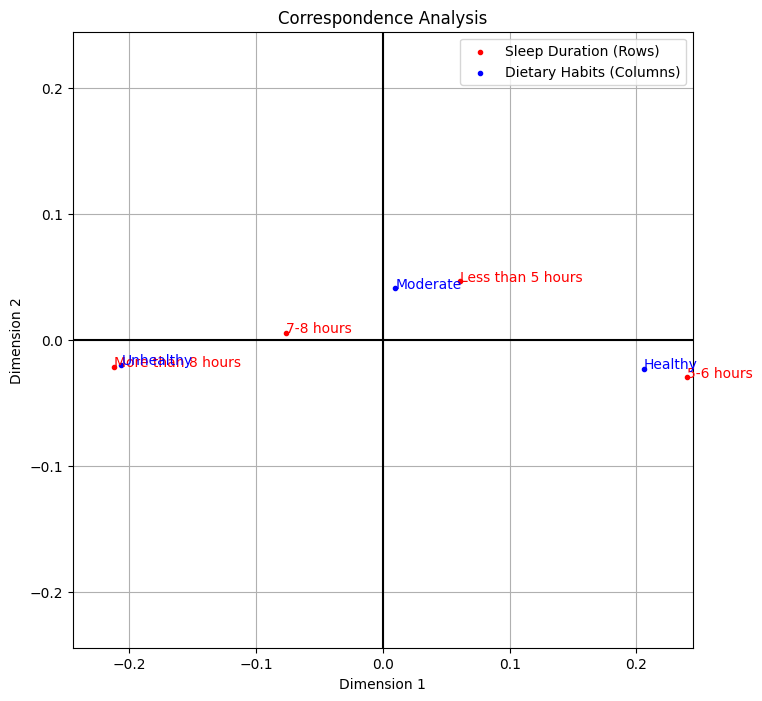

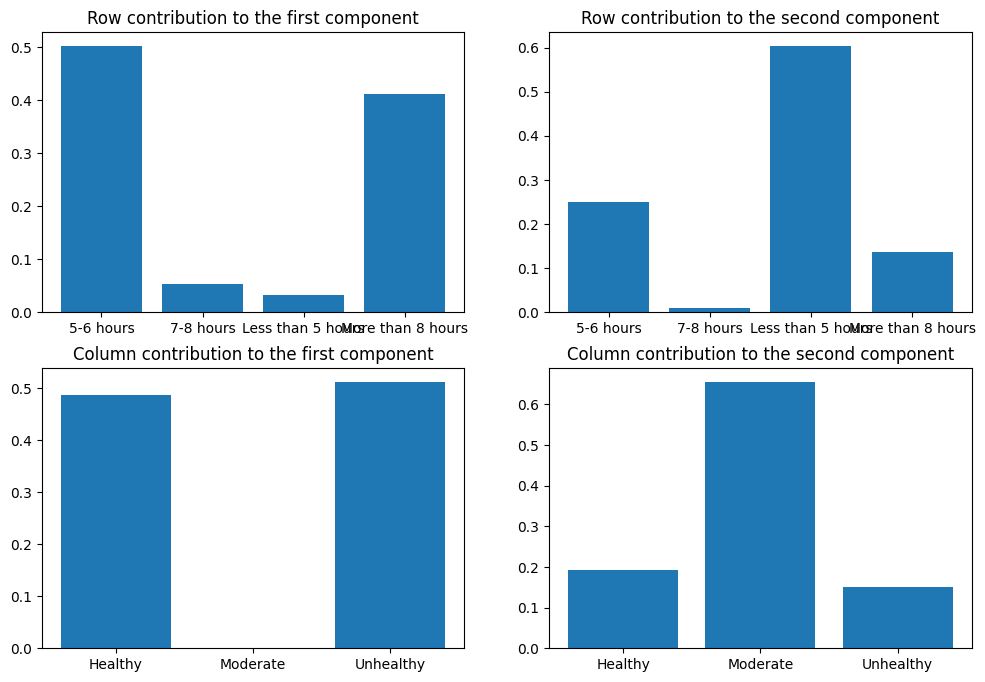

In [98]:
index_column1, index_column2 = 4, 5

make_plot(df, index_column1, index_column2, -1) # Tout le monde

Contingency table:
Dietary Habits     Healthy  Moderate  Unhealthy
Sleep Duration                                 
5-6 hours               30        19         10
7-8 hours               24        22         15
Less than 5 hours       23        26         10
More than 8 hours       20        23         28

p-value of the chi-2 test:  0.022318891679873488

Eigenvalues summary:
          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.051        85.81%                     85.81%
1              0.008        14.19%                    100.00%



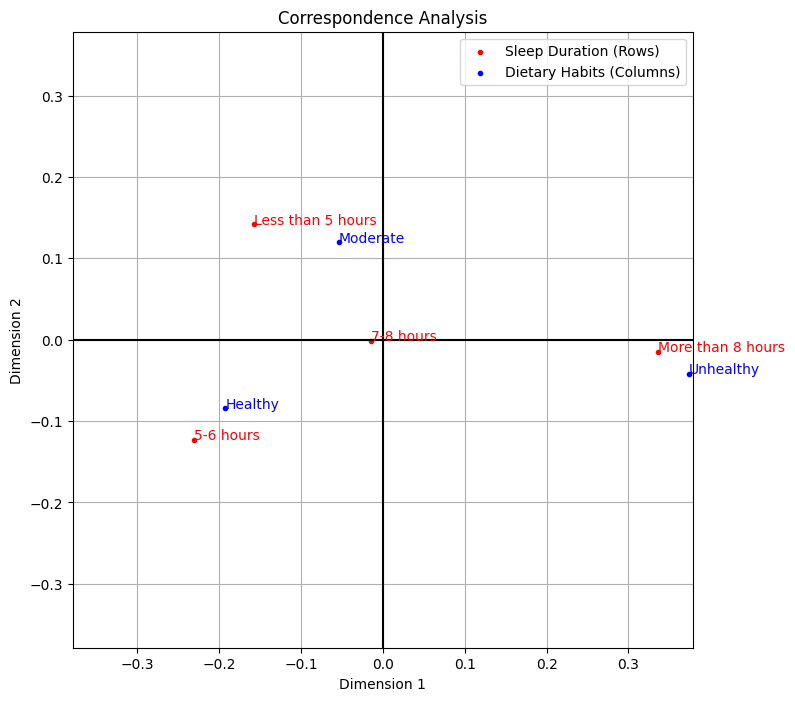

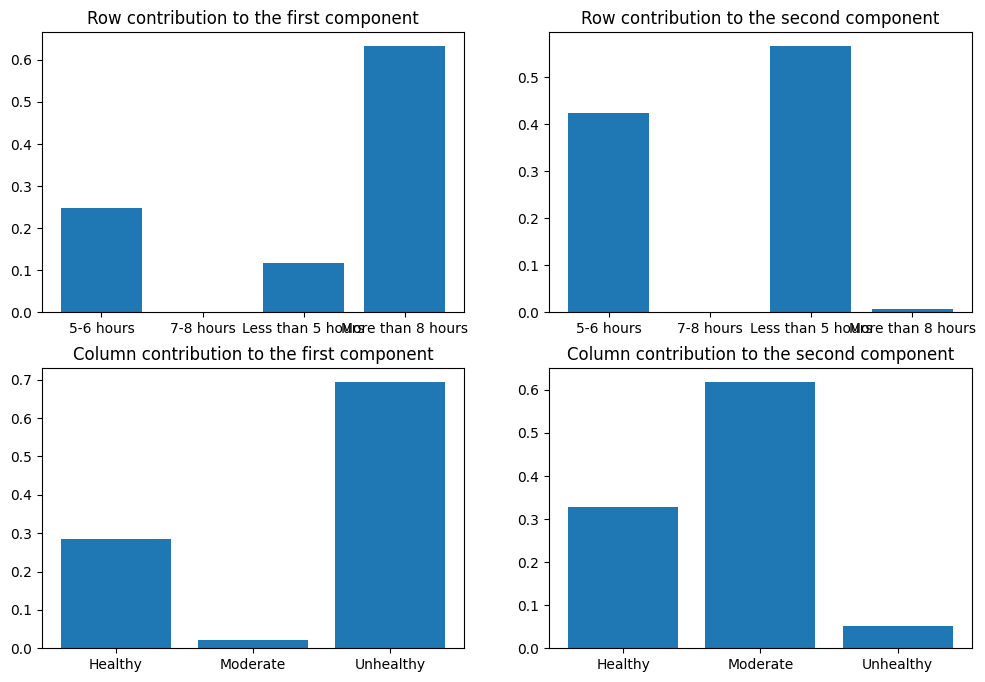

In [99]:
index_column1, index_column2 = 4, 5

make_plot(df, index_column1, index_column2, 0) # Tout le monde